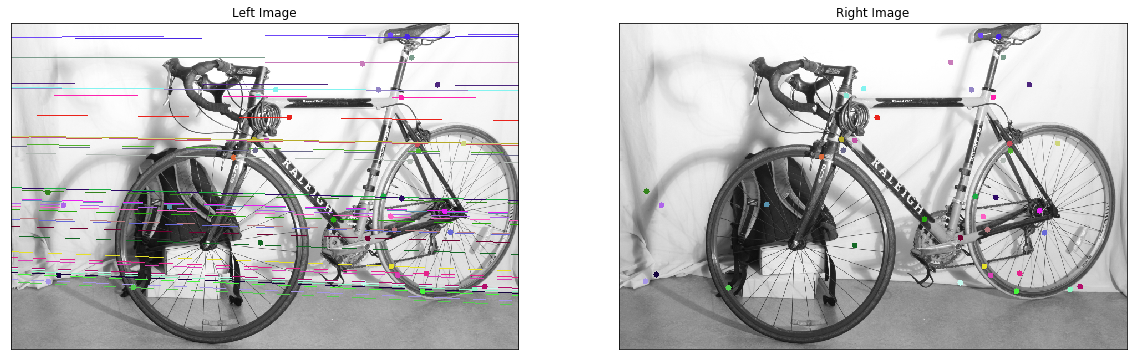

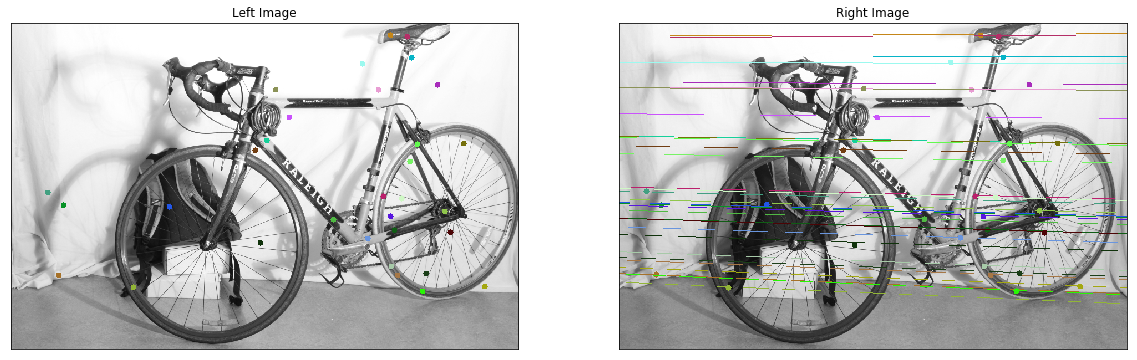

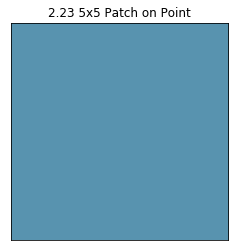

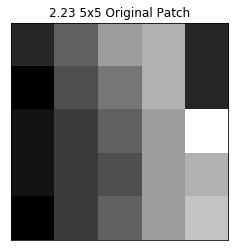

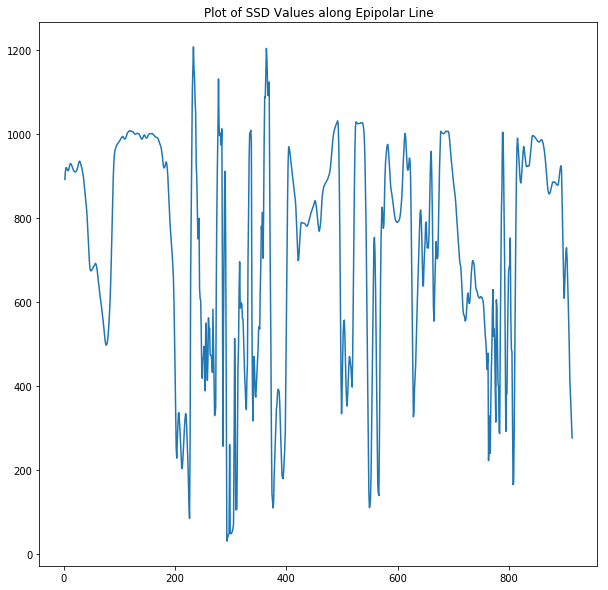

y coordinate
293
SSD value:
29.8496231131986


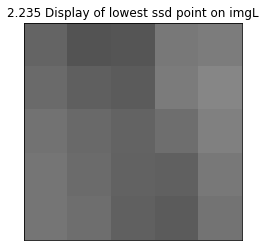

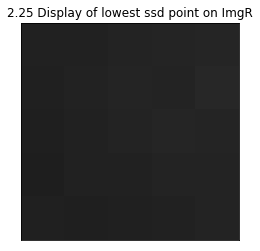

In [8]:
#2.2 Epipolar Geometry 

import cv2
import numpy as np
import matplotlib.pyplot as plt

#function for drawing lines 
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    r, c = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color, use the same color to plot the line
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

#2.2 Epipolar Geometry 
#2.1 compute matching SIFT keypoints from a stereo image pair

#load image pairs
imgL = cv2.imread("im0.png", cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread("im1.png", cv2.IMREAD_GRAYSCALE)

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

#imgL = cv2.imread("img1.png", cv2.COLOR_BGR2RGB)
#imgR = cv2.imread("img0.png", cv2.COLOR_BGR2RGB)

# we need to find as many possible matches between two images to find
# the fundamental matrix
#create sift object
sift = cv2.xfeatures2d.SIFT_create()

#find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)
#bfMatcher = cv2.BFMatcher()

# Match descriptors.
matches = bfMatcher.match(desL,desR)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2)

#2.22 Compute and display the epipolar lines for both images 
# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.32 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

    
# find the Fundamental Matrix
ptsL = np.int64(ptsL)
ptsR = np.int64(ptsR)


# LMEDS: least meadian square
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Epilines corresponding to points in the first image is drawn on the
# second image

#ptsL = ptsL[mask.ravel()==1]
#ptsR = ptsR[mask.ravel()==1]

linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines

imgL1, imgR1 = drawlines(imgL, imgR, linesL[160:225], ptsL[160:225], ptsR[160:225])

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)

imgR2, imgL2 = drawlines(imgR, imgL, linesR[170:225], ptsR[170:225], ptsL[170:225])

# display images
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()


#2.23 Pick a point that doesnt match and extract 5x5 around it 

# by printing the list of points on the right image using print(ptsR), we have a point on the front wheel of the bicycle
#at coordinates (266,329) that is slightly mismatched on the left image with the epipolar lines

point_x, point_y = 266, 329

# i extracted the same patch from both imgR1 and imgR just to show that it is infact the correct point
patch = imgR1[point_y - 3:point_y + 2, point_x -3 : point_x+ 2]

#extract a 5x5 around that point, on the original image 
patch2 = imgR[point_y - 3:point_y + 2, point_x -3 : point_x+ 2]


plt.imshow(patch, cmap="gray")
plt.title("2.23 5x5 Patch on Point"), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(patch2, cmap="gray")
plt.title("2.23 5x5 Original Patch"), plt.xticks([]), plt.yticks([])
plt.show()

#2.24
#Match extracted patch using SSD with every patch along the corresponding epipolar line in left image
ssds = []
yvalue=[]
min_val = float('inf')
min_horz = float('inf')

# # loop through 5x5 patches on the foundLine on left image to find a match using SSD
#img width is 916
for p in range(2, 916 -2):
    yvalue.append(p)
    #traverse patch horizontally along keypoint 
    #y value of keypoint is 329
    patchL = imgL[329-2:329+3, p-2:p+3]
    result = np.absolute(np.array(patchL) - np.array(patch2))
    result2= np.linalg.norm(patchL - patch2)
    ssds.append(np.linalg.norm(patchL - patch2))
    if result2 < min_val:
        min_horz = p
        min_val = result2
ssds = np.array(ssds)


#2.25
#Plot SSD values 
plt.figure(figsize=(10,10))
plt.title("Plot of SSD Values along Epipolar Line")
plt.plot(yvalue, ssds)
plt.show()
#Find matching point with minimum SSD value, display matching points in both images 
#Matching point found from above, y coordinate of min_horz
#y coordinate is 293
print('y coordinate')
print(min_horz)
print('SSD value:')
print(min_val)

matchingpoints = imgR1[293 - 3:293 + 2, 266 -3 : 266+ 2]
matchingpoints2 = imgL1[293 - 3:293 + 2, 266 -3 : 266+ 2]


plt.imshow(matchingpoints2, cmap="gray")
plt.title("2.235 Display of lowest ssd point on imgL"), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(matchingpoints, cmap="gray")
plt.title("2.25 Display of lowest ssd point on ImgR"), plt.xticks([]), plt.yticks([])
plt.show()



2.26: Yes, i found exactly one point with lowest SSD, this was not the correct point. This is because i chose a keypoint that has no match on left image, basically a keypoint that is not on the epipolar line. So, it will not find the proper keypoint as i only searched along this line. 
